In [14]:
#//----------------------------
#//LIBRARIES
    #Math
import math
    #Numeric Python
import numpy as np
    #Pandas (dataframes)
import pandas as pd
    #datetime for fate manipulation
from datetime import date, datetime, timedelta  
    #Regex for advanced string matching
import re
    #for time related stuff
import time
    #json library
import json
    #Analyst tools
import sys
sys.path.append('../')
from analysts_tools.growth import *
    #Procurement tools
from procurement_lib import send_slack_notification
from procurement_lib import redash
from analysts_tools.redash_methods import *

import random
import time
import datetime

from sklearn.model_selection import train_test_split 

In [15]:
#//---------------------------------------------------------------------------------------------------------------------------
#// Parametros

city_code = 'BAQ'

skus = [450459,456909]
#year-month-day
todays_date = datetime.datetime.today().strftime('%Y-%m-%d')

dias = 0

tasas = {'BOG': 3776,
         'BAQ': 3776,
         'MDE': 3776,
         'CMX': 19.65,
         'GDL': 19.65,
         'PBC': 19.65,
         'SPO': 4.75,
         'BHZ': 4.75,
         'CWB': 4.75,
         'VCP': 4.75}

t_cambio = tasas[city_code]

In [16]:
frida_products = get_fresh_query_result("https://internal-redash.federate.frubana.com/",118629,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [17]:
clients_CLTV = get_fresh_query_result("https://internal-redash.federate.frubana.com/",154541,'SeoGHWmDUaaBi7VXje1s9zYNiMD1VHQ1K1DYOxiF',{},20)

200


In [18]:
best_customers = clients_CLTV.loc[(clients_CLTV.region_code == city_code) & (clients_CLTV.cltv.isin([1,2,3,4,5,6,7,8,9]))].customer_id.unique()

In [19]:
clients_CLTV.loc[(clients_CLTV.region_code == city_code) & (clients_CLTV.cltv.isin([1,2,3,4,5,6,7,8,9]))].customer_id.nunique()

4466

In [20]:
query = """
-- 93058
-- Se toma como base el query 2718
WITH 
ful AS (

SELECT DISTINCT
    bo.order_id,
    --ffg.close_date
    bo.submit_date
    
FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_group" bfg        ON bfg.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_fulfillment_order" bfo        ON bfo.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_fulfillment_group" ffg         ON ffg.fulfillment_group_id = bfg.fulfillment_group_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order" fo                      ON fo.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_payment" bop            ON bop.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site" s                       ON s.site_id = bo.site_disc
LEFT JOIN  postgres_broadleaf_federate."broadleaf.fb_order_type" fot                ON fot.fb_order_type_id=fo.fb_order_type_id

WHERE fo.fb_order_status_id IN (1,6,7,8)
    AND bo.submit_date >= DATE_TRUNC('day', date(getdate()) - interval '90 day')
    AND bo.order_status = 'SUBMITTED'
    AND bfo.status NOT IN ('ARCHIVED','CANCELLED')
    AND bop.archived = 'N'
    AND (fot.name IS NULL OR fot.name <> 'REFUND')
    AND s.site_identifier_value = '{ciudad}'
)

SELECT DISTINCT
    s.site_identifier_value AS city,
    DATE(bo.submit_date) AS submit_date,
    bo.customer_id,
    bs2.name,
    bs.addl_product_id as padre_sku_id,
    --bcat2.name AS category,
    --bcat.name AS subcat,
    --MIN(bo.submit_date) AS min_date,
    --COUNT(DISTINCT bo.order_id) as orders,
    CASE WHEN s.site_identifier_value = 'CMX' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/19.65)
        WHEN s.site_identifier_value = 'GDL' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/19.65)
        WHEN s.site_identifier_value = 'PBC' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/19.65)
        WHEN s.site_identifier_value = 'MTY' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/19.65)
        WHEN s.site_identifier_value = 'SPO' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/4.75)
        WHEN s.site_identifier_value = 'BHZ' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/4.75)
        WHEN s.site_identifier_value = 'CWB' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/4.75)
        WHEN s.site_identifier_value = 'VCP' then SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/4.75)
    ELSE SUM ( (boi.quantity * foi.step_unit * boi.sale_price)*1.0/3776) END AS gmv_usd,
    SUM(boi.quantity* foi.step_unit) as cant

FROM postgres_broadleaf_federate."broadleaf.blc_order" bo
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_site"                     s       ON s.site_id = bo.site_disc
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item"               boi     ON boi.order_id=bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order_item"                foi     ON boi.order_item_id= foi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.fb_order"                     fo      ON fo.order_id = bo.order_id
INNER JOIN ful                                                                          ON ful.order_id = bo.order_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_discrete_order_item"      bdoi    ON bdoi.order_item_id = boi.order_item_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs      ON bs.sku_id = bdoi.sku_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_product"                  bp      ON bs.addl_product_id = bp.product_id
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_sku"                      bs2     ON bs2.sku_id = bp.default_sku_id --Conectar la tarjeta con el sku que guarda la info
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat    ON bcat.category_id = bp.default_category_id 
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category_xref"            bcx     ON bcx.sub_category_id = bp.default_category_id AND bcx.archived='N' AND bcx.sndbx_tier is NULL
INNER JOIN postgres_broadleaf_federate."broadleaf.blc_category"                 bcat2   ON bcx.category_id = bcat2.category_id
--INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_price_dtl"     boipd   ON boipd.order_item_id=boi.order_item_id
--INNER JOIN postgres_broadleaf_federate."broadleaf.blc_order_item_dtl_adj"       boida   ON boida.order_item_price_dtl_id=boipd.order_item_price_dtl_id

WHERE fb_order_status_id IN (1,6,7,8)
    AND bo.order_status = 'SUBMITTED'
   -- FIX SUPER DESCUENTOS
    AND bcat2.category_id not in ('110873','-1000','100768','100765','100815') --ids de super descuentos en cada país
    AND bcat.name <> 'Oferton Frubana' AND bcat2.name <> 'Oferton Frubana'
    --AND LOWER(boida.adjustment_reason) ILIKE '%merma%'
    
GROUP BY 1,2,3,4,5
ORDER BY 1,3,5,2
""".format(ciudad=city_code)

data_ventas_aux = read_connection_data_warehouse.runQuery(query)
data_ventas_aux[["gmv_usd","cant"]] = data_ventas_aux[["gmv_usd","cant"]].astype(float)
data_ventas_aux["submit_date"] = pd.to_datetime(data_ventas_aux["submit_date"])

In [21]:
from sklearn.model_selection import train_test_split 

def create_groups(time_between_purchases_df,st_time_between_purchases,sku):
    
    customers = time_between_purchases_df.loc[(time_between_purchases_df.time_between_purchases > st_time_between_purchases.loc[0,['50%']][0]) &
                                    (time_between_purchases_df.customer_id.isin(best_customers))].customer_id.unique()

    customer_control, customer_test = train_test_split(customers, test_size = 0.80)

    alpha=0.01
    aux=0
    while abs(1-(data_ventas_aux[(data_ventas_aux.customer_id.isin(customer_control)) & (data_ventas_aux.padre_sku_id == sku)]['gmv_usd'].mean()/data_ventas_aux[data_ventas_aux.customer_id.isin(customer_test) & (data_ventas_aux.padre_sku_id == sku)]['gmv_usd'].mean())) > alpha:
        customer_control, customer_test = train_test_split(customers, test_size = 0.80)
        
        aux+=1
        if aux == 1000:
            alpha+=0.01
            aux=0
        
    return customer_control.tolist(), customer_test.tolist()

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def plott(time_between_purchases_df,st_time_between_purchases):
    # Set the figure size
    plt.figure(figsize=(14, 8))
    fig, ax = plt.subplots()

    # Extract the 'time_between_purchases' column from the DataFrame
    time_between_purchases = time_between_purchases_df['time_between_purchases'].dropna().astype('timedelta64[D]').astype(int)

    # Create the histogram with a density curve
    sns.histplot(time_between_purchases, kde=True, binwidth=2, ax=ax)

    # Add a vertical line at the mean value
    mean_val = st_time_between_purchases.loc[0,['mean']][0].total_seconds() / 86400
    plt.axvline(x=mean_val, color='red', linestyle='--', label='Median')

    # Set the x-axis limits
    ax.set_xlim(left=0, right=50)

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

    st_time_between_purchases
    
    return "done"

In [23]:
def get_data(sku):
    grouped_data = data_ventas_aux.loc[data_ventas_aux.padre_sku_id == sku].groupby(['customer_id', 'padre_sku_id'])
    time_between_purchases = grouped_data['submit_date'].diff()
    time_between_purchases_df = pd.DataFrame({'customer_id': data_ventas_aux.loc[data_ventas_aux.padre_sku_id == sku]['customer_id'],
                                            'padre_sku_id': data_ventas_aux.loc[data_ventas_aux.padre_sku_id == sku]['padre_sku_id'],
                                            'time_between_purchases': time_between_purchases})
    avg_time_between_purchases = time_between_purchases_df.groupby(['padre_sku_id'])['time_between_purchases'].mean()
    st_time_between_purchases = time_between_purchases_df.groupby(['padre_sku_id'])['time_between_purchases'].describe().reset_index()
    
    plott(time_between_purchases_df,st_time_between_purchases)
    print(st_time_between_purchases)
    control,test = create_groups(time_between_purchases_df,st_time_between_purchases,sku)
    return control,test

<Figure size 1008x576 with 0 Axes>

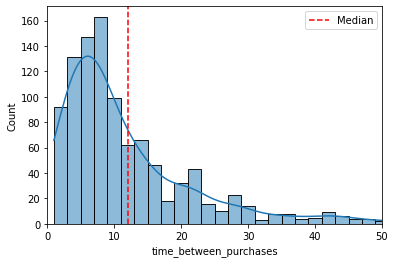

   padre_sku_id count                       mean                        std  \
0        450459  1031 12 days 01:43:21.357904946 11 days 01:12:04.227004438   

     min    25%    50%     75%     max  
0 1 days 5 days 8 days 15 days 68 days  
450459 CONTROL:  41  TEST:  168


<Figure size 1008x576 with 0 Axes>

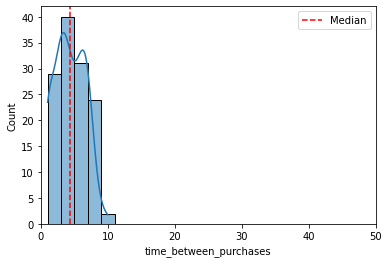

   padre_sku_id count                      mean                       std  \
0        456909   126 4 days 07:25:42.857142857 2 days 05:08:41.452400329   

     min    25%    50%    75%     max  
0 1 days 3 days 4 days 6 days 10 days  
456909 CONTROL:  6  TEST:  24


In [24]:
offer_name = []
global_segment_list = [] #//for procesing
for sku in skus:
    control,test = get_data(sku)

    offer_name.append("SH_CLTV_"+todays_date+"_"+city_code+"_"+str(sku))
    d = {'name':"SH_CLTV_"+todays_date+"_"+city_code+"_"+str(sku), 'customersIds': list(test)}
    e = {'name':"SH_CLTV_"+todays_date+"_"+city_code+"_"+str(sku)+"_CONTROL", 'customersIds': list(control)}
    
    global_segment_list.append(d)
    global_segment_list.append(e)
    
    print(sku,"CONTROL: ",len(control), " TEST: ",len(test))

In [25]:
csv_file = {} 
csv_file['offer_name'] = offer_name
csv_file['offer_description'] = None
csv_file['discount'] = [6.5,6.5]
csv_file['automatically_consider_offer'] = "true"
csv_file['start_date'] = (datetime.datetime.today() + datetime.timedelta(days=dias)).strftime('%d-%m-%Y')
csv_file['end_date'] = (datetime.datetime.today() + datetime.timedelta(days=(dias+15))).strftime('%d-%m-%Y')
csv_file['max_uses_per_order'] = [0]*len(offer_name)
csv_file['max_uses_per_customer'] = [0]*len(offer_name)
csv_file['customer_segment_id'] = [1]*len(offer_name) #[None]
csv_file['sku_id'] = [frida_products.loc[frida_products.id_tarjeta == sku,"skus"].values[0] for sku in skus]

global_offer_csv = pd.DataFrame(csv_file) #, index=[0])

In [26]:
global_offer_csv

,offer_name,offer_description,discount,automatically_consider_offer,start_date,end_date,max_uses_per_order,max_uses_per_customer,customer_segment_id,sku_id
0,SH_CLTV_2023-05-20_BAQ_450459,None,6.5,true,20-05-2023,04-06-2023,0,0,1,624989
1,SH_CLTV_2023-05-20_BAQ_456909,None,6.5,true,20-05-2023,04-06-2023,0,0,1,632389


In [27]:
import requests
import json

url = f"https://{city_code}.frubana.com/api/v1/segments/create?api-key=00_growth-team-zzz-qqq_001"

payload = json.dumps(global_segment_list)


headers = {
  'Cookie': 'AWSALB=WGKrKvA1CFOY0m92xSENGAseuE4LrcfQh9y8jK/loGBJdizNm+FvjOqUqVghxdfLkH6Jsa9sfWft2NELchGAP/LNZMXMYhrOE70qDnUuOHATpdJj1UZBMEUBSIN1; AWSALBCORS=WGKrKvA1CFOY0m92xSENGAseuE4LrcfQh9y8jK/loGBJdizNm+FvjOqUqVghxdfLkH6Jsa9sfWft2NELchGAP/LNZMXMYhrOE70qDnUuOHATpdJj1UZBMEUBSIN1; AWSALB=jLY02FPysvF1vTrKLhXbk3ibzmyiAqFJ1ezYVu5PjodkU2QmPHDpRJhb9CvOlOyQ1Ix0mJR1ig+eH9zwJ9i5EOtgsgx79NSROogQb2Ua6yLX/I3bJJ6xtcVO3puI; AWSALBCORS=jLY02FPysvF1vTrKLhXbk3ibzmyiAqFJ1ezYVu5PjodkU2QmPHDpRJhb9CvOlOyQ1Ix0mJR1ig+eH9zwJ9i5EOtgsgx79NSROogQb2Ua6yLX/I3bJJ6xtcVO3puI',
  'Content-Type': 'application/json'
}

response = requests.request("POST", url, headers=headers, data=payload)

In [28]:
sgt = [(int(x[:6]),x[7:]) for x in list(map(str.strip, response.text[32:].strip('][').replace('"', '').split(',')))]

In [29]:
for i in global_offer_csv.offer_name:
    for j,z in sgt:
        if z==i:
            global_offer_csv.loc[global_offer_csv.offer_name == i, ('customer_segment_id')] = j
            break

In [30]:
global_offer_csv

,offer_name,offer_description,discount,automatically_consider_offer,start_date,end_date,max_uses_per_order,max_uses_per_customer,customer_segment_id,sku_id
0,SH_CLTV_2023-05-20_BAQ_450459,None,6.5,true,20-05-2023,04-06-2023,0,0,162309,624989
1,SH_CLTV_2023-05-20_BAQ_456909,None,6.5,true,20-05-2023,04-06-2023,0,0,162308,632389


In [31]:
#//--------------------------------------------
#//Exporting single file data
global_offer_csv.to_csv(f'{todays_date}_EXP_CLTV_{city_code}_OFFER.csv', index = False)